In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable


from torchvision.utils import save_image
from IPython.core.display import Image, display

import numpy as np
import matplotlib.pyplot as plt
from vae import VAE



In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [56]:
bsz = 200
epochs = 10
seqlen = 16

z_size = 32
n_hidden = 256
n_gaussians = 5

In [57]:
#Q HERE

In [58]:
z = torch.from_numpy(np.load('z.npy'))
print(z.shape)
#z = z.view(bsz, -1, z.size(1)).to(device)
z.shape

torch.Size([12001, 1, 32])


torch.Size([12001, 1, 32])

In [59]:
z

tensor([[[-0.2498, -0.0563, -0.1624,  ...,  0.1034,  0.1617,  0.0963]],

        [[ 0.1358, -0.0288, -0.0641,  ..., -0.1029, -0.0410,  0.0640]],

        [[-0.1854, -0.2106, -0.0891,  ...,  0.0092, -0.0656,  0.1128]],

        ...,

        [[ 0.0940, -0.4762, -0.0837,  ..., -0.1419,  0.0068,  0.6605]],

        [[-0.2836, -0.1047, -0.2405,  ...,  0.1004, -0.1189, -0.1479]],

        [[ 0.0108, -0.1142,  1.6550,  ..., -0.0376,  0.1301,  0.4181]]])

In [60]:
# Truncated backpropagation
def detach(states):
    return [state.detach() for state in states] 

In [87]:
class MDNRNN(nn.Module):
    def __init__(self, z_size, n_hidden=256, n_gaussians=5, n_layers=1):
        super(MDNRNN, self).__init__()

        self.z_size = z_size
        self.n_hidden = n_hidden
        self.n_gaussians = n_gaussians
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(z_size, n_hidden, n_layers, batch_first=True)
        self.fc1 = nn.Linear(n_hidden, n_gaussians*z_size)
        self.fc2 = nn.Linear(n_hidden, n_gaussians*z_size)
        self.fc3 = nn.Linear(n_hidden, n_gaussians*z_size)
        
    def get_mixture_coef(self, y):
        rollout_length = y.size(1)
        pi, mu, sigma = self.fc1(y), self.fc2(y), self.fc3(y)
        
        pi = pi.view(-1, rollout_length, self.n_gaussians, self.z_size)
        mu = mu.view(-1, rollout_length, self.n_gaussians, self.z_size)
        sigma = sigma.view(-1, rollout_length, self.n_gaussians, self.z_size)
        
        pi = F.softmax(pi, 2)
        sigma = torch.exp(sigma)
        return pi, mu, sigma
        
        
    def forward(self, x, h):
        # Forward propagate LSTM
        
        print('===')
        print(x.shape)
        print((h[0].shape))
        
        
        y, (h, c) = self.lstm(x, h)
        pi, mu, sigma = self.get_mixture_coef(y)
        return (pi, mu, sigma), (h, c)
    
    def init_hidden(self, bsz):
        return (torch.zeros(self.n_layers, bsz, self.n_hidden).to(device),
                torch.zeros(self.n_layers, bsz, self.n_hidden).to(device))

In [88]:
model = MDNRNN(z_size, n_hidden).to(device)
# model.load_state_dict(torch.load('rnn.torch', map_location='cpu'))

In [89]:
model

MDNRNN(
  (lstm): LSTM(32, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=160, bias=True)
  (fc2): Linear(in_features=256, out_features=160, bias=True)
  (fc3): Linear(in_features=256, out_features=160, bias=True)
)

In [64]:
def mdn_loss_fn(y, pi, mu, sigma):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=2)
    loss = -torch.log(loss)
    return loss.mean()

In [65]:
def criterion(y, pi, mu, sigma):
    y = y.unsqueeze(2)
    return mdn_loss_fn(y, pi, mu, sigma)

In [66]:
optimizer = torch.optim.Adam(model.parameters())

In [70]:
# Train the model
for epoch in range(epochs):
    # Set initial hidden and cell states
    hidden = model.init_hidden(bsz)

    
    for i in range(0, z.size(1) - seqlen, seqlen):
        # Get mini-batch inputs and targets
        inputs = z[:, i:i+seqlen, :]
        targets = z[:, (i+1):(i+1)+seqlen, :]
        

        
        # Forward pass
        hidden = detach(hidden)
        
        
        (pi, mu, sigma), hidden = model(inputs, hidden)
        
        loss = criterion(targets, pi, mu, sigma)

        
        # Backward and optimize
        model.zero_grad()
        loss.backward()
        # clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
    if epoch % 100 == 0:
        print (epoch, epochs)

0 10


In [48]:
# np.linalg.norm(z[0, 0, :].cpu().data - z1[0, :, :].cpu().data, axis=1)
# np.linalg.norm(inputs.cpu().data - targets.cpu().data)

In [16]:
#RNN Predict

In [17]:
vae = VAE(image_channels=3).to(device)
vae.load_state_dict(torch.load('vae.torch', map_location='cpu'))

<All keys matched successfully>

In [18]:
vae

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)

===
torch.Size([1, 1, 32])
torch.Size([1, 1, 256])


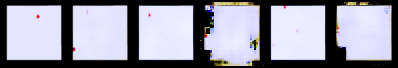

In [90]:
zero = np.random.randint(z.size(0))
one = np.random.randint(z.size(1))
x = z[zero:zero+1, one:one+1, :]
y = z[zero:zero+1, one+1:one+2, :]


x = x.cuda()
y = y.cuda()

hidden = model.init_hidden(1)
(pi, mu, sigma), _ = model(x, hidden)

y_preds = [torch.normal(mu, sigma)[:, :, i, :] for i in range(n_gaussians)]



comp = torch.cat([[x, y][0] , y_preds[0], y_preds[1], y_preds[2], y_preds[3], y_preds[4] ])

#compare_x = vae.decode(torch.cat([x, y] + y_preds))
#compare_x = vae.decode([x, y][0])
#compare_x = vae.decode(y_preds[0])

compare_x = vae.decode(comp)



# compare_x = vae.decode(z_out)
save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=1000, unconfined=True))

In [20]:
y_preds[1]
[x, y][0].shape
y_preds[0].shape

torch.Size([1, 1, 32])

In [21]:
torch.cat([[x, y][0] , y_preds[0], y_preds[1], y_preds[2], y_preds[3], y_preds[4] ])

tensor([[[ 0.7418, -0.0714, -0.2175, -0.5127,  1.1116,  0.4516, -0.0623,
           0.4681, -0.1985, -0.3506, -0.1640,  0.1563, -0.0413, -0.3044,
           0.2665,  0.0166, -0.1539, -0.1232,  0.0553, -0.1292, -0.9484,
          -0.4234, -0.7035,  0.1539, -0.1083,  0.6316,  0.2350,  0.4670,
           0.2233,  0.2988, -0.0156, -0.2042]],

        [[-0.7710,  1.1366,  0.9650, -1.1234, -0.9939, -2.4625,  0.4505,
          -0.5594,  0.1348,  1.0435, -0.6658,  0.0141, -0.0317,  0.1517,
           0.9528, -0.5861, -1.0782,  0.3262,  0.7128,  1.0025,  0.1378,
           0.9619, -0.3077, -0.9055, -0.0299,  1.0633,  0.4665,  1.8153,
          -0.1405, -0.2992,  0.3169,  1.6671]],

        [[ 0.8633,  0.5687, -0.9135, -0.4973,  0.7798, -1.7187,  1.4213,
          -1.2760, -0.3857, -0.0787, -0.7399,  2.3492,  0.2363,  0.6579,
           0.0499, -0.1173,  0.9284, -2.8093,  1.3367, -0.2187,  0.2062,
          -1.2918, -1.4648,  1.4222,  1.3665, -0.2361, -1.3507,  0.1358,
           1.2534,  1.2602